In [94]:
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.animation as animation
from numpy.core.fromnumeric import size
from SimFunctions import SimulationFunctions

def exercise2(KP, KD, del_time, noise_fac):
    ## Parameters
    # Movement duration
    T=.6
    # Time step
    dt=.01
    # Simulation duration
    L=6.0
    # Proportional parameter
    kp = KP
    # Derivative parameter
    kd= KD
    # Upper arm length
    le1=.3
    # Lower arm length
    le2=.3
    # Upper arm mass
    m1=3
    # Lower arm mass
    m2=3
    # Gravity
    g=-9.8


    ## Functions
    Var = [T,dt,L,kp,kd,le1,le2,m1,m2,g]
    Sim = SimulationFunctions(Var)

    ## Variables
    # Joint angles [shoulder elbow]

    ang=[-np.pi/4, np.pi]
    ang_rec=np.zeros((int(L/dt+1),2))
    delayed_ang=ang[:]
    # Joint velocity [shoulder elbow]
    vel=[0, 0]
    vel_rec=np.zeros((int(L/dt+1),2))
    delayed_vel=vel[:]
    # Joint acceleration [shoulder elbow]
    acc=[0, 0]
    acc_rec=np.zeros((int(L/dt+1),2))
    # Jerk [shoulder elbow]
    jerk_rec=np.zeros((int(L/dt+1),2))
    # Shoulder position
    shoulder_pos=[0, 0]
    # Elbow position
    elbow_pos=[0, 0]
    # Wrist position
    wrist_pos=np.zeros((2))
    wrist_pos_rec=np.zeros((int(L/dt+1),2))
    # Initial wrist position for current movement
    init_wrist_pos=wrist_pos
    # Desired wrist position
    final_wrist_pos=[[0.3, 0.0],  [0.0, 0.0],  [.3*np.cos(np.pi/4), .3*np.sin(np.pi/4)],  [0.0, 0.0], 
                    [0.0, .3],  [0.0, 0.0],  [.3*np.cos(3*np.pi/4), .3*np.sin(3*np.pi/4)],  [0.0, 0.0]]
    # Current target index
    curr_target=0
    # Movement start_time
    start_t=0

    # TODO define time steps of delay
    delay_time = del_time
    ## Simulation

    ## Reset variables
    fig, ax = plt.subplots(1, 1, figsize=(12,8))
    ax.set_xlabel('meters', fontsize=10)
    ax.set_ylabel('meters', fontsize=10)
    ax.set_xlim([-0.5, .5])
    ax.set_ylim([-0.5, .5])

    Time = time.time()
    for t in np.arange(0,int(L),dt):

        # Update records
        ang_rec[round(t/dt)+1,:]=ang
        vel_rec[round(t/dt)+1,:]=vel
        acc_rec[round(t/dt)+1,:]=acc
        if t>0:
            jerk_rec[round(t/dt)+1,:]=acc-acc_rec[round(t/dt),:]
        
                
        ## Current wrist target
        current_wrist_target=final_wrist_pos[curr_target][:]

        if curr_target<=7:
            ## Planner
            # Get desired position from planner
            if t-start_t<T:
                desired_pos=Sim.minjerk(init_wrist_pos, current_wrist_target, t-start_t)
            
            ## Inverse kinematics
            # Get desired angle from inverse kinematics
            desired_ang=np.real(Sim.invkinematics(desired_pos))

            ## Inverse dynamics
            ## TODO Define delayed angles and velocities
            if (round((t)/dt)) > delay_time:
                delayed_ang = ang_rec[round((t)/dt)-delay_time,:]
                delayed_vel = vel_rec[round((t)/dt)-delay_time,:]
        
            ## TODO Compute torque with delayed angles and velocities
            desired_torque=Sim.pdcontroller(desired_ang, delayed_ang, delayed_vel)

            # Get desired torque from PD controller
            # desired_torque=Sim.pdcontroller(desired_ang, ang, vel)
                
            ## Forward dynamics
            ## TODO DEFINE NOISE - you can use randn
            factor = noise_fac
            noise = factor * np.random.randn(2)
            ## TODO ADD NOISE to torque
            desired_torque = desired_torque +  noise

            # Pass torque to plant
            [ang,vel,acc]= Sim.plant(ang,vel,acc,desired_torque)

            ## Forward kinematics
            # Calculate new joint positions
            [elbow_pos, wrist_pos] = Sim.fkinematics(ang)

            # Record wrist position
            wrist_pos_rec[round(t/dt)+1,:]=wrist_pos.T
            

            ## Next target
            if (t-start_t>=T+.02) & (curr_target<7):
                curr_target=curr_target+1
                init_wrist_pos=wrist_pos
                start_t=t
            
        

    # # # Plot arm, wrist path, and targets -- ANIMATION 

        # print([shoulder_pos[0], elbow_pos[0][0]], [shoulder_pos[1], elbow_pos[1][0]])
        # print([elbow_pos[0][0], wrist_pos[0]], [elbow_pos[1][0], wrist_pos[1]])

        # ax.cla()
        # ax.scatter(np.array(final_wrist_pos)[:,0], np.array(final_wrist_pos)[:,1], color='green')
        # ax.scatter(np.array(final_wrist_pos)[:,0], np.array(final_wrist_pos)[:,1], color='green')

        # ax.plot([shoulder_pos[0], elbow_pos[0][0]], [shoulder_pos[1], elbow_pos[1][0]], color='blue')
        # ax.plot([elbow_pos[0][0], wrist_pos[0][0]], [elbow_pos[1][0], wrist_pos[1][0]], color= 'blue')   
        # plt.pause(0.01)
        # plt.tight_layout()

        # for t2 in np.arange(dt,t,dt):
        #     ax.cla()
        #     ax.plot(wrist_pos_rec[:round(t2/dt),0], wrist_pos_rec[:round(t2/dt),1],'--',color='red',linewidth=0.5)
            
        #     ax.plot([wrist_pos_rec[round(t2/dt),0], wrist_pos_rec[round(t2/dt)+1,0]], [wrist_pos_rec[round(t2/dt),1], wrist_pos_rec[round(t2/dt)+1,1]],color='red',linewidth=0.5)
        #     plt.show(block=False)
        #     plt.pause(0.01)
        #     ax.cla()
        # ax.autoscale_view()

    elapsed = time.time() - Time
    print("Time elapsed:",elapsed)

    ax.plot(wrist_pos_rec[:-1,0], wrist_pos_rec[:-1,1],'--',color='red',linewidth=0.5)
    ax.scatter(np.array(final_wrist_pos)[:,0], np.array(final_wrist_pos)[:,1], color='green')
    ax.title.set_text('KP = ' + str(KP) + ', KD = ' + str(KD) + ', Delay = ' + str(del_time) + ', Noise = ' + str(noise_fac))
    ax.set_xlim([-0.3, .4])
    ax.set_ylim([-0.1, .4])
    plt.show()

    plt.subplot(3,1,1)
    plt.title('KP = ' + str(KP) + ', KD = ' + str(KD) + ', Delay = ' + str(del_time) + ', Noise = ' + str(noise_fac))
    [A,B]= plt.plot(np.arange(0,L-dt,dt), [xx[0] for xx in vel_rec[:int(L/dt)-1]],np.arange(0,L-dt,dt), [xx[1] for xx in vel_rec[:int(L/dt)-1]])
    plt.legend([A,B],['Shoulder','Elbow'])
    plt.xlabel('time (ms)')
    plt.ylabel('velocity')
    plt.subplot(3,1,2)
    [A,B]= plt.plot(np.arange(0,L-dt,dt), [xx[0] for xx in acc_rec[:int(L/dt)-1]],np.arange(0,L-dt,dt), [xx[1] for xx in acc_rec[:int(L/dt)-1]])
    plt.legend([A,B],['Shoulder','Elbow'])
    plt.xlabel('time (ms)')
    plt.ylabel('acceleration')
    plt.subplot(3,1,3)
    [A,B]= plt.plot(np.arange(0,L-dt,dt), [xx[0] for xx in jerk_rec[:int(L/dt)-1]],np.arange(0,L-dt,dt), [xx[1] for xx in jerk_rec[:int(L/dt)-1]])
    plt.legend([A,B],['Shoulder','Elbow'])
    plt.xlabel('time (ms)')
    plt.ylabel('jerk')
    plt.tight_layout()
    plt.show()

Time elapsed: 0.19678282737731934


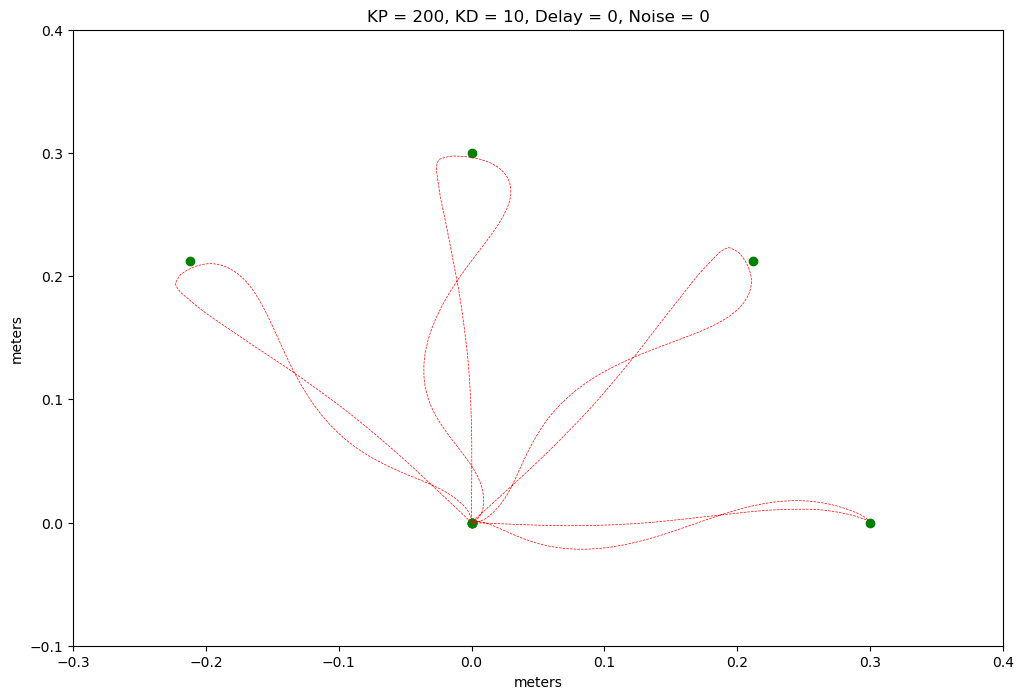

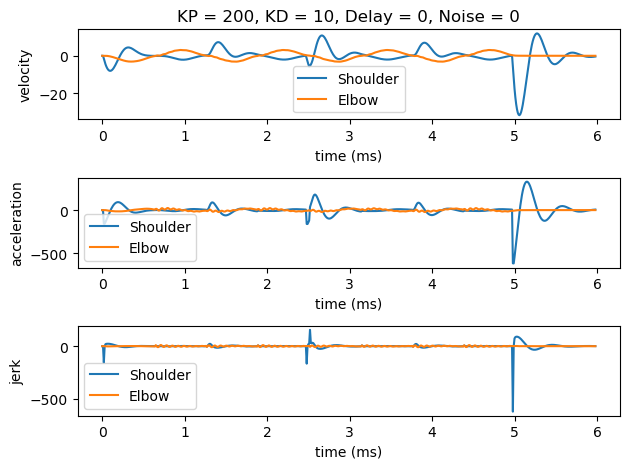

d:\visualstudio\Bioinspired_Marcel\Bioinspired-Marcel\Week2\2.2\2.2Python_version\SimFunctions.py:59: RuntimeWarning: overflow encountered in scalar power
  t_load[0]=(self.m1*self.g*(self.le1/2)*np.sin(ang[0])) + (acc[0]*(inertia[0]+inertia[1]+self.m2*self.le1*self.le2*np.cos(ang[1])+(self.m1*self.le1**2+self.m2*self.le2**2)/4+self.m2*self.le1**2)) + (acc[1]*(inertia[1]+(self.m2*self.le2**2)/4+(self.m2*self.le1*self.le2)/2*np.cos(ang[1]))) + ((-(self.m2*self.le1*self.le2)/2)*vel[1]**2) + -self.m2*self.le1*self.le2*vel[0]*vel[1]*np.sin(ang[1])
d:\visualstudio\Bioinspired_Marcel\Bioinspired-Marcel\Week2\2.2\2.2Python_version\SimFunctions.py:59: RuntimeWarning: overflow encountered in scalar multiply
  t_load[0]=(self.m1*self.g*(self.le1/2)*np.sin(ang[0])) + (acc[0]*(inertia[0]+inertia[1]+self.m2*self.le1*self.le2*np.cos(ang[1])+(self.m1*self.le1**2+self.m2*self.le2**2)/4+self.m2*self.le1**2)) + (acc[1]*(inertia[1]+(self.m2*self.le2**2)/4+(self.m2*self.le1*self.le2)/2*np.cos(ang[1]))) + 

Time elapsed: 0.20237088203430176


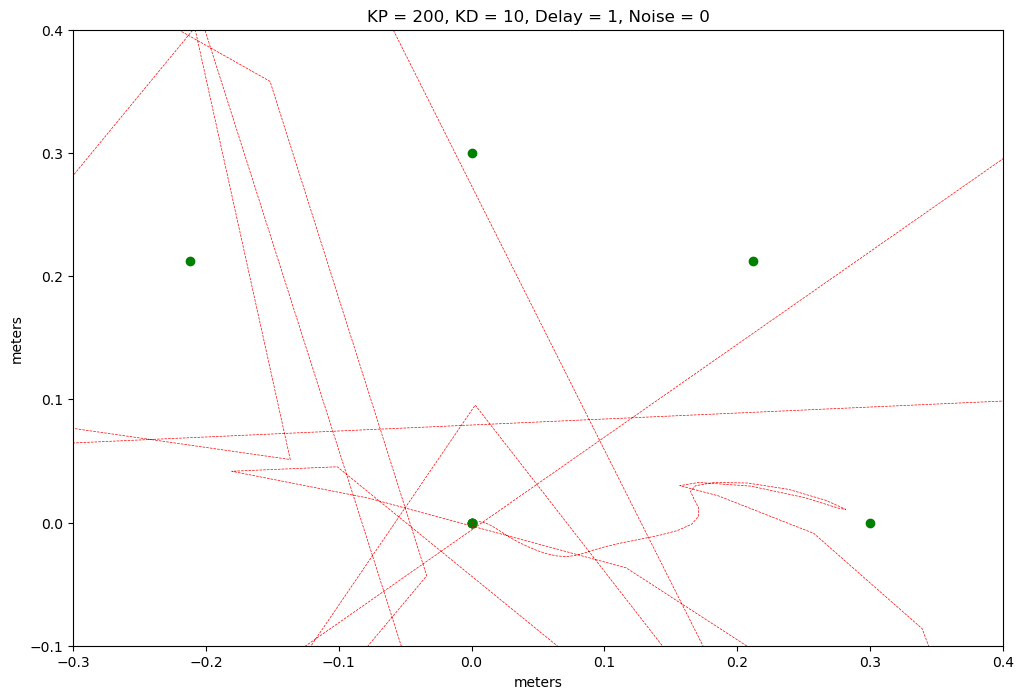

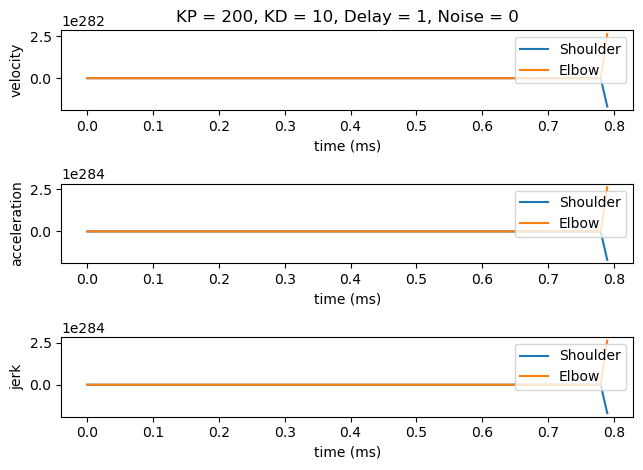

Time elapsed: 0.19782352447509766


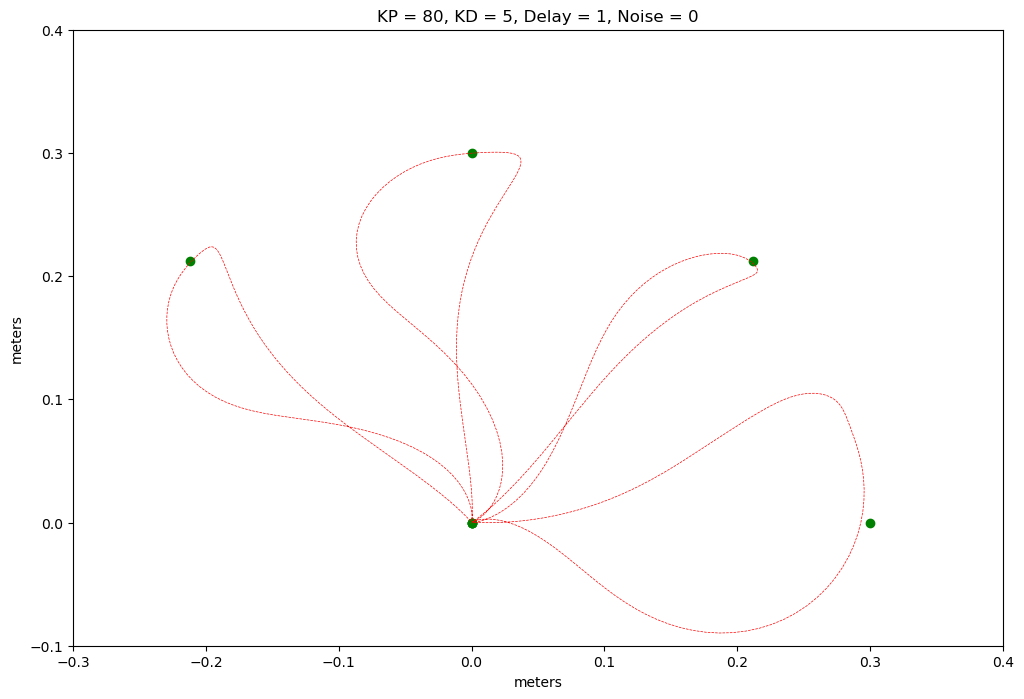

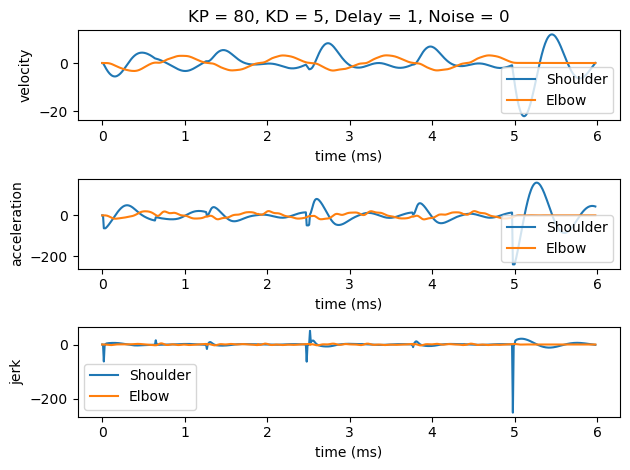

In [102]:
## Exercise 2 - 1

# exercise2(200,10, 0, 0)
# exercise2(200,10, 0, 2)
# exercise2(200,10, 0, 10)
# exercise2(200,10, 0, 20)

## Exercise 2 - 2

# exercise2(200,10, 0, 0)
# exercise2(200,10, 1, 0)

## Exercise 2 - 3

exercise2(200,10, 0, 0)
exercise2(200,10, 1, 0)
exercise2(80,5, 1, 0)

# exercise2(200,10, 1)
# exercise2(200,10, 2)
# exercise2(80, 5, 1)

# for i in range(1,300, 100):
#     print("Kp:", i)
#     for b in range(1, 20, 1):
#         exercise2(100, b, 1)

# for i in range(1,20, 2):
#     print("B:", i)
#     exercise2(20, i, 2)
        